In [1]:
import os
import time
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="*", force=True))
import pickle
import gzip
import copy
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
import torchvision
# from curriculum_deeplab.data_parameters import DataParamMode
import torchio as tio

import matplotlib.pyplot as plt
from IPython.display import display
import nibabel as nib
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import KFold

from mdl_seg_class.metrics import dice3d, dice2d
from mdl_seg_class.visualization import visualize_seg
from curriculum_deeplab.mindssc import mindssc

from pathlib import Path

import wandb
import random
import glob
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

print(torch.__version__)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  -------------
   3  NVIDIA GeForce RTX 2080 Ti     0 %   11018 MiB  11.5(495.29.05)
   2  NVIDIA GeForce RTX 2080 Ti     0 %    9937 MiB  11.5(495.29.05)  grossbroehmer
   0  NVIDIA GeForce RTX 2080 Ti     0 %    2575 MiB  11.5(495.29.05)  schneider
   1  NVIDIA GeForce RTX 2080 Ti    29 %    7389 MiB  11.5(495.29.05)  weihsbach

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   3  NVIDIA GeForce RTX 2080 Ti  ->  cuda:0
1.9.0a0+gitdfbd030
8204
NVIDIA GeForce RTX 2080 Ti


In [2]:
def in_notebook():
    try:
        get_ipython().__class__.__name__
        return True
    except NameError:
        return False

if in_notebook:
    THIS_SCRIPT_DIR = os.path.abspath('')
else:
    THIS_SCRIPT_DIR = os.path.dirname(os.path.realpath(__file__))
print(f"Running in: {THIS_SCRIPT_DIR}")

Running in: /share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab


floral-monkey-1148_fold0_epx39/train_label_snapshot.pth has 20000 parameters.


/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


disturbed_bool_vect nan
gt_sum -0.07902478874467611
dice 0.010146705699850959
pp_sum -0.026564646392120375
sqrt_gt_sum -0.23989955012603015
log_gt_sum -0.4290102565357523
e_log_gt_sum -0.411866552914928
inv_e_log_gt_sum 0.47620611008370123
Corr coeff DP_weight/dice 0.01 vs. DP_reweight/dice with gt_sum -0.27
Corr coeff DP_weight/dice 0.01 vs. DP_reweight/dice with pp_sum -0.13
Corr coeff DP_weight/dice 0.01 vs. DP_reweight/dice with sqrt_gt_sum -0.27
Corr coeff DP_weight/dice 0.01 vs. DP_reweight/dice with log_gt_sum -0.22
Corr coeff DP_weight/dice 0.01 vs. DP_reweight/dice with e_log_gt_sum -0.13
Corr coeff DP_weight/dice 0.01 vs. DP_reweight/dice with inv_e_log_gt_sum 0.13


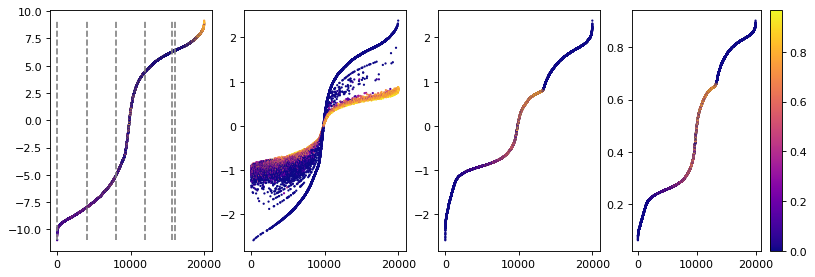

noble-forest-1144_fold0_epx39/train_label_snapshot.pth has 20000 parameters.
disturbed_bool_vect nan
gt_sum -0.5410462113063257
dice -0.42612189107946047
pp_sum -0.3269926410781727
sqrt_gt_sum -0.6638110141095572
log_gt_sum -0.752484840176439
e_log_gt_sum -0.7483810873139796
inv_e_log_gt_sum 0.7601961013667993
Corr coeff DP_weight/dice -0.43 vs. DP_reweight/dice with gt_sum -0.41
Corr coeff DP_weight/dice -0.43 vs. DP_reweight/dice with pp_sum -0.33
Corr coeff DP_weight/dice -0.43 vs. DP_reweight/dice with sqrt_gt_sum -0.41
Corr coeff DP_weight/dice -0.43 vs. DP_reweight/dice with log_gt_sum -0.42
Corr coeff DP_weight/dice -0.43 vs. DP_reweight/dice with e_log_gt_sum -0.43
Corr coeff DP_weight/dice -0.43 vs. DP_reweight/dice with inv_e_log_gt_sum -0.41


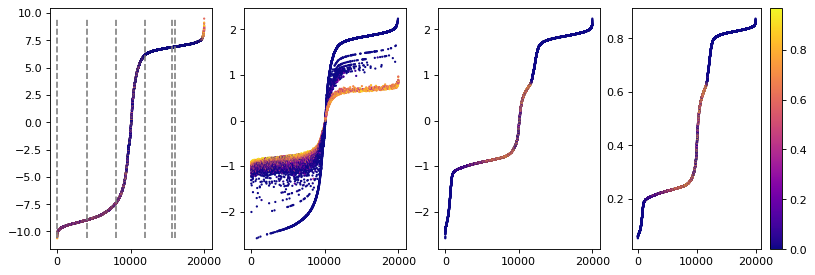

dummy-o6pTEKxVBMKHVLYvqrwJWn_fold0_epx39/train_label_snapshot.pth has 3600 parameters.
disturbed_bool_vect -0.43180202885120106
gt_sum 0.5733328799457567
dice 0.5817717729431975
pp_sum 0.5195389713908213
sqrt_gt_sum 0.543251352337919
log_gt_sum 0.39909102474354324
e_log_gt_sum 0.41430357768907483
inv_e_log_gt_sum -0.34278304365696655
Corr coeff DP_weight/dice 0.58 vs. DP_reweight/dice with gt_sum 0.65
Corr coeff DP_weight/dice 0.58 vs. DP_reweight/dice with pp_sum 0.52
Corr coeff DP_weight/dice 0.58 vs. DP_reweight/dice with sqrt_gt_sum 0.65
Corr coeff DP_weight/dice 0.58 vs. DP_reweight/dice with log_gt_sum 0.71
Corr coeff DP_weight/dice 0.58 vs. DP_reweight/dice with e_log_gt_sum 0.72
Corr coeff DP_weight/dice 0.58 vs. DP_reweight/dice with inv_e_log_gt_sum 0.45


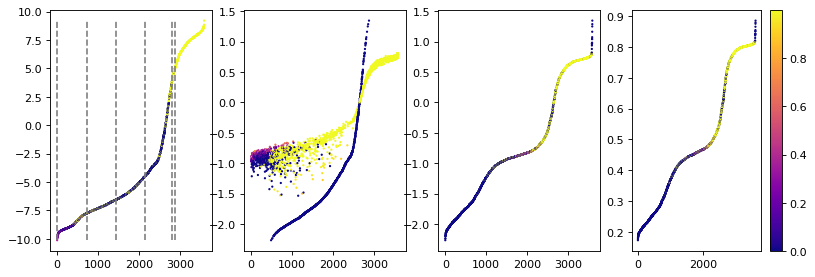

neat-disco-1147_fold0_epx39/train_label_snapshot.pth has 20000 parameters.
disturbed_bool_vect nan
gt_sum -0.16704032296779528
dice -0.07315346596600077
pp_sum -0.11465177300780471
sqrt_gt_sum -0.3330479766721134
log_gt_sum -0.5152617715001482
e_log_gt_sum -0.49960477330328107
inv_e_log_gt_sum 0.5577324071505118
Corr coeff DP_weight/dice -0.07 vs. DP_reweight/dice with gt_sum -0.34
Corr coeff DP_weight/dice -0.07 vs. DP_reweight/dice with pp_sum -0.21
Corr coeff DP_weight/dice -0.07 vs. DP_reweight/dice with sqrt_gt_sum -0.34
Corr coeff DP_weight/dice -0.07 vs. DP_reweight/dice with log_gt_sum -0.29
Corr coeff DP_weight/dice -0.07 vs. DP_reweight/dice with e_log_gt_sum -0.20
Corr coeff DP_weight/dice -0.07 vs. DP_reweight/dice with inv_e_log_gt_sum 0.05


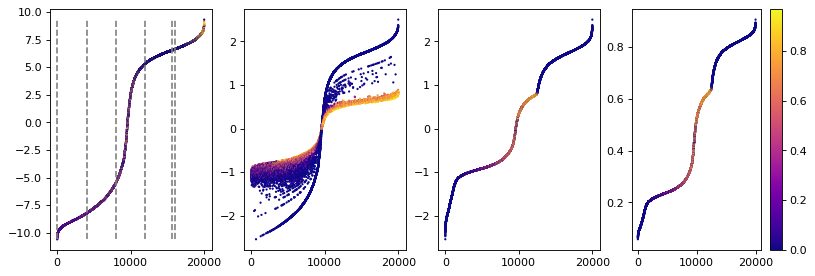

In [3]:
file_paths = [
    # '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/crimson-oath-956_fold0_epx39/train_label_snapshot.pth',
    # '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/_clean-morning-918_fold0_epx39/train_label_snapshot.pth'
    '/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/noble-forrest-1144_fold0_epx39/train_label_snapshot.pth'
]

file_paths = glob.glob('./data/output/**/*.pth')

for _path in file_paths:
    data = torch.load(_path)
    if not 'disturb_flags' in data: continue
    dp_mean_weight = data['data_parameters'].squeeze().detach().cpu()
    disturb_flags = data['disturb_flags'] 
    d_ids = data['d_ids'] 
    dataset_idxs = data['dataset_idxs'] 
    _2d_labels = data['labels']
    _2d_modified_labels = data['modified_labels']
    _2d_predictions = data['train_predictions']
    print(f"{'/'.join(_path.split('/')[-2:])} has {len(dp_mean_weight)} parameters.")

    _2d_labels = _2d_labels.to_dense()
    _2d_modified_labels = _2d_modified_labels.to_dense()
    _2d_predictions = _2d_predictions.to_dense()

    gt_sum = _2d_modified_labels.sum((-2,-1))
    pp_sum = _2d_predictions.sum((-2,-1)).squeeze(1).cpu()
    rgt_sum =  _2d_labels.sum((-2,-1)).cpu()
    intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
    dice = 2*intersect/(rgt_sum+gt_sum+1)

    all_elems = \
        dict(
            disturbed_bool_vect = torch.tensor(disturb_flags).float(),
            gt_sum=gt_sum, 
            dice=dice, 
            pp_sum=pp_sum,
            sqrt_gt_sum=np.sqrt(gt_sum),
            log_gt_sum=np.log(gt_sum+1)+1, # this seems to be right
            e_log_gt_sum=np.log(gt_sum+np.exp(1))+np.exp(1),
            inv_e_log_gt_sum=1/(np.log(gt_sum+np.exp(1))+np.exp(1)),
        )
    
    for name, metric in all_elems.items():
        print(name, np.corrcoef(dp_mean_weight.cpu().detach(), metric.detach())[0,1])
    for name, metric in all_elems.items():
        if name in ['dice', 'disturbed_bool_vect']: continue
        
        print(f"Corr coeff DP_weight/dice {np.corrcoef(dp_mean_weight.detach(), dice.detach())[0,1]:.2f} vs. DP_reweight/dice with {name} {np.corrcoef((dp_mean_weight/(metric+1e-6)).cpu().detach(), dice.detach())[0,1]:.2f}")
    reweighted = dp_mean_weight/(all_elems['e_log_gt_sum'])

    # sel_idxs = reweighted<100
    sel_idxs = range(len(reweighted))
    srtd_reweighted = reweighted[sel_idxs]
    srtd_dice_reweighted = dice[sel_idxs]

    srtd = sorted(zip(srtd_reweighted, srtd_dice_reweighted))
    srtd_reweighted, srtd_dice_reweighted = zip(*srtd)
    srtd_reweighted, srtd_dice_reweighted = torch.stack(srtd_reweighted), torch.stack(srtd_dice_reweighted)

    # Show weights and weights with compensation
    fig, axs = plt.subplots(1,4, figsize=(12, 4), dpi=80)
    sc1 = axs[0].scatter(
        range(len(dp_mean_weight)), 
        dp_mean_weight.cpu().detach(), c=dice,s=1, cmap='plasma');
    sc2 = axs[1].scatter(
        range(len(dp_mean_weight)), 
        reweighted.cpu().detach(), 
        s=1,c=dice, cmap='plasma')
    sc3 = axs[2].scatter(
        range(len(srtd_reweighted)), 
        srtd_reweighted.detach().numpy(), 
        s=1,c=srtd_dice_reweighted, cmap='plasma');
    sc4 = axs[3].scatter(
        range(len(srtd_reweighted)), 
        torch.sigmoid(srtd_reweighted-srtd_reweighted.mean()).detach().numpy(), 
        s=1,c=srtd_dice_reweighted, cmap='plasma');
    plt.colorbar(sc4)
    axs[0].vlines(len(dp_mean_weight)*.0, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.2, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.4, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.6, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.78, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    axs[0].vlines(len(dp_mean_weight)*.8, dp_mean_weight.min(), dp_mean_weight.max(), colors='gray', linestyles='dashed')
    plt.show()

In [3]:
# ref_lbl_data = torch.load('/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/dummy-QixDEpd5qwWzhnFo884Q5S_fold0_epx39/train_label_snapshot.pth')
# ref_ids = ref_lbl_data['d_ids']
data = torch.load('/share/data_supergrover1/weihsbach/shared_data/tmp/curriculum_deeplab/data/output/noble-forest-1144_fold0_epx39/train_label_snapshot.pth')
dp_mean_weight = data['data_parameters'].squeeze().detach().cpu()
d_ids = data['d_ids']
d_idxs = data['dataset_idxs']

# sel_ref_idxs = [ref_ids.index(_id) for _id in d_ids if _id in ref_ids]
# dp_mean_weight = dp_mean_weight[10000:]

_2d_labels = data['labels']
_2d_modified_labels = data['modified_labels']
_2d_predictions = data['train_predictions']

_2d_labels = _2d_labels.to_dense()
_2d_modified_labels = _2d_modified_labels.to_dense()
_2d_predictions = _2d_predictions.to_dense()
print("Data loaded.")

Data loaded.


In [21]:
# show_img = interpolate_sample(b_label=_labels, scale_factor=scf, use_2d=use_2d)[1].unsqueeze(1)
# show_seg = interpolate_sample(b_label=_predictions.squeeze(1), scale_factor=scf, use_2d=use_2d)[1]
# show_gt = interpolate_sample(b_label=_modified_labels, scale_factor=scf, use_2d=use_2d)[1]
overlay_text_list = [f"id:{d_id} dp:{instance_p.item():.2f}" \
    for d_id, instance_p in zip(d_ids, dp_mean_weight)]
limit = 800

# show_img = _2d_labels[-limit:]
# show_seg = _2d_predictions[-limit:]
# show_gt = _2d_modified_labels[-limit:]

# show_img = _2d_labels[non_nan_dice_idxs][srt][-limit:]
# show_seg = _2d_predictions[non_nan_dice_idxs][srt][-limit:]
# show_gt = _2d_modified_labels[non_nan_dice_idxs][srt][-limit:]

In [22]:
idx_sort = np.argsort(d_idxs)[:limit]
srt_overlay_text_list = [overlay_text_list[idx] for idx in idx_sort.tolist()]
srt_show_img = _2d_labels[idx_sort].cuda()
srt_show_seg = _2d_predictions[idx_sort].cuda()
srt_show_gt = _2d_modified_labels[idx_sort].cuda()

visualize_seg(in_type='batch_2D', #reduce_dim=reduce_dim,
    img=srt_show_img.unsqueeze(1), # Expert label in BW
    seg=4*srt_show_seg.squeeze(), # Prediction in blue
    ground_truth=srt_show_gt, # Modified label in red
    # crop_to_non_zero_gt=True,
    alpha_seg = .5,
    alpha_gt = .5,
    n_per_row=50,
    overlay_text=srt_overlay_text_list,
    annotate_color=(0,255,255),
    # frame_elements=disturb_flags,
    file_path="out.png",
)

RuntimeError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 10.76 GiB total capacity; 9.47 GiB already allocated; 320.56 MiB free; 9.77 GiB reserved in total by PyTorch)

In [4]:
from mdl_seg_class.metrics import dice3d, dice2d
dice = torch.zeros(_2d_labels.shape[0])

for idx in range(_2d_labels.shape[0]):
    dice[idx] = dice2d(
        torch.nn.functional.one_hot(_2d_modified_labels[idx:idx+1], 2), # Calculate dice score with original segmentation (no disturbance)
        torch.nn.functional.one_hot(_2d_labels[idx:idx+1], 2),
        one_hot_torch_style=True, nan_for_unlabeled_target=True
    )[0,1]

In [5]:
print(_2d_modified_labels.shape)
print(torch.isnan(dice).sum())
print((dice>0).sum())

non_nan_dice_idxs = ~torch.isnan(dice)

torch.Size([20000, 256, 256])
tensor(6877)
tensor(7989)


In [6]:
import scipy
wise_corr_coeff = np.corrcoef(dp_mean_weight[non_nan_dice_idxs].cpu().detach(), dice[non_nan_dice_idxs].cpu().detach())[0,1]
print(wise_corr_coeff)
spearman_corr_coeff, spearman_p = scipy.stats.spearmanr(dp_mean_weight[non_nan_dice_idxs].cpu().detach(), dice[non_nan_dice_idxs].cpu().detach())
print(spearman_corr_coeff)

-0.1467296885922519
-0.1627611968881278


/tmp/ipykernel_2086543/417815077.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(sc1)


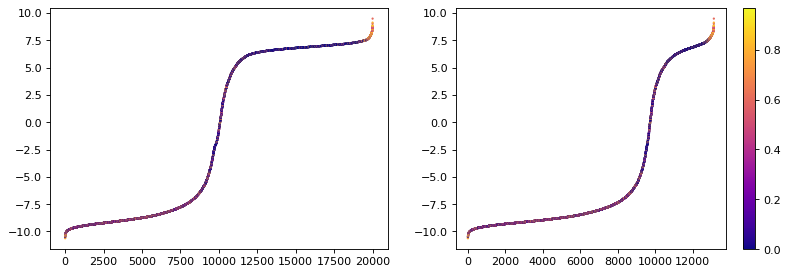

In [8]:
# Show weights and weights with compensation
fig, axs = plt.subplots(1,2, figsize=(12, 4), dpi=80)
sc1 = axs[0].scatter(
    range(len(dp_mean_weight)), 
    dp_mean_weight.cpu().detach(), 
    c=dice,
    s=1, cmap='plasma');
sc2 = axs[1].scatter(
    range(len(dp_mean_weight[non_nan_dice_idxs])), 
    dp_mean_weight[non_nan_dice_idxs].cpu().detach(), 
    c=dice[non_nan_dice_idxs],
    s=1, cmap='plasma');
plt.colorbar(sc1)
plt.show()

In [ ]:
print(gt_sum[-20:])

print(dp_mean_weight[-20:])
dp_mean_weight[-20:]/(1+np.exp(1))
# (np.log(gt_sum+np.exp(1))+np.exp(1))

print(len(dp_mean_weight))
print(len(gt_sum))

print(reweighted[-20:])


In [ ]:
def interpolate_sample(b_image=None, b_label=None, scale_factor=1.,
                       yield_2d=False):
    if yield_2d:
        scale = [scale_factor]*2
        im_mode = 'bilinear'
    else:
        scale = [scale_factor]*3
        im_mode = 'trilinear'

    if b_image is not None:
        b_image = F.interpolate(
            b_image.unsqueeze(1), scale_factor=scale, mode=im_mode, align_corners=True,
            recompute_scale_factor=False
        )
        b_image = b_image.squeeze(1)

    if b_label is not None:
        b_label = F.interpolate(
            b_label.unsqueeze(1).float(), scale_factor=scale, mode='nearest',
            recompute_scale_factor=False
        ).long()
        b_label = b_label.squeeze(1)

    return b_image, b_label
selected_weight = reweighted
data = zip(selected_weight, d_ids, _2d_labels, _2d_modified_labels, _2d_predictions)


samples_sorted = sorted(data, key=lambda tpl: tpl[0])
(dp_weightss, d_idss, _2d_lbl, _2d_ml, _2d_p) = zip(*samples_sorted)

overlay_text_list = [f"id:{d_id} gwd:{instance_p.item():.2f}" \
    for d_id, instance_p in zip(d_idss, dp_weightss)]

visualize_seg(in_type="batch_2D",
    img=interpolate_sample(b_label=torch.stack(_2d_lbl), scale_factor=.5, yield_2d=True)[1].unsqueeze(1),
    seg=interpolate_sample(b_label=4*torch.stack(_2d_p).squeeze(1), scale_factor=.5, yield_2d=True)[1],
    ground_truth=interpolate_sample(b_label=torch.stack(_2d_ml), scale_factor=.5, yield_2d=True)[1],
    crop_to_non_zero_seg=False,
    alpha_seg = .5,
    alpha_gt = .5,
    n_per_row=70,
    overlay_text=overlay_text_list,
    annotate_color=(0,255,255),
    file_path="out_reweight.png",
)

In [ ]:
torch.save(
    {
        'reweighted_weigths': sg_reweighted,
        'd_ids': d_ids 
    }, 
    'fixed_weights.pth'
)


In [ ]:
correction = \
    [
        1.0,
        1/(1+gt_sum).numpy(), 
        1/(1+np.sqrt(gt_sum)).numpy(),
        1/np.log(gt_sum+gt_sum.max().sqrt()).numpy(),
    ]

for crr in correction:
    print(np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy()*crr, dice)[0,1])


In [ ]:
import glob
import pandas as pd
corrs = {}
def get_corr_coeff(inp):
    return np.corrcoef(torch.tensor(dp_mean_weight).cpu().detach().numpy(), inp)[0,1]

for pth in glob.glob('./data/output/**/*.pth'):
    print(pth)
    data = torch.load(pth)
    dp_mean_weight, *_, d_ids, dataset_idxs, _2d_labels, _2d_modified_labels = data
    gt_sum = _2d_modified_labels.sum((-2,-1))
    pp_sum = _2d_labels.sum((-2,-1))
    intersect = torch.logical_and(_2d_labels, _2d_modified_labels).sum((-2,-1))
    dice = 2*intersect/(pp_sum+gt_sum)
    all_elems = dict(
            gt_sum=get_corr_coeff(gt_sum),
            intersect=get_corr_coeff(intersect),
            pp_sum=get_corr_coeff(pp_sum),
            sqrt=get_corr_coeff(np.sqrt(gt_sum)),
            log=get_corr_coeff(np.log(gt_sum+gt_sum.max().sqrt())), # this seems to be right
            dice=get_corr_coeff(dice)
    )
    corrs[pth.split('/')[-2]] = all_elems
    # break
df = pd.DataFrame(corrs)
df.to_csv('pd.csv')
print(df)
